In [16]:
import os
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
import sys
from tqdm import tqdm
import numpy as np
from numpy.fft import fft2, fftshift
import matplotlib.pyplot as plt


plt.rcParams["image.cmap"] = "jet"

In [17]:
# Setting path
# path = Path("Y:/ptychosaxs")  # /net/micdata/data2/12IDC mounted windows drive
path = Path("/net/micdata/data2/12IDC/ptychosaxs/")
# Join paths
MODEL_SAVE_PATH = path / 'trained_model/' # Automatically adds the correct separator
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)
print(MODEL_SAVE_PATH)

/net/micdata/data2/12IDC/ptychosaxs/trained_model


In [18]:
# Load preprocessed data
num='ZC4'#17
numDPs=10800#10000

# Load the data
data_path = os.path.abspath(os.path.join(os.getcwd(), f'../../data/processed/preprocessed_dir{num}_numDPs{numDPs}.npz'))
data = np.load(data_path)

# Extract the arrays
amp_conv_red = data['amp_conv_red']
amp_ideal_red = data['amp_ideal_red']
amp_probe_red = data['amp_probe_red']

In [19]:
# Set the number of patterns in test, train or validation set
NTEST = amp_conv_red.shape[0]//4
NTRAIN = amp_conv_red.shape[0]-NTEST
NVALID = NTEST//2 # NTRAIN//

print(NTRAIN,NTEST,NVALID)

8100 2700 1350


In [20]:
EPOCHS = 500
NGPUS = torch.cuda.device_count()
BATCH_SIZE = NGPUS*16
LR = NGPUS * 1e-3
print("GPUs:", NGPUS, "Batch size:", BATCH_SIZE, "Learning rate:", LR)

no_probe=True
H,W=amp_ideal_red[0].shape[0],amp_ideal_red[0].shape[1]
print(H,W)

GPUs: 2 Batch size: 32 Learning rate: 0.002
256 256


In [21]:
#separate data and convert to tensors and shuffle
no_probe=True

tst_start = amp_conv_red.shape[0]-NTEST

X_train = amp_conv_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
X_test = amp_conv_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Xp_train = amp_probe_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Xp_test = amp_probe_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

Y_I_train = amp_ideal_red[:NTRAIN].reshape(-1,H,W)[:,np.newaxis,:,:]
Y_I_test = amp_ideal_red[tst_start:].reshape(-1,H,W)[:,np.newaxis,:,:]

ntrain=X_train.shape[0]
ntest=X_test.shape[0]

X_train, Xp_train, Y_I_train = shuffle(X_train, Xp_train, Y_I_train, random_state=0)

#Training data
X_train_tensor = torch.Tensor(X_train)
Xp_train_tensor = torch.Tensor(Xp_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 

#Test data
X_test_tensor = torch.Tensor(X_test)
Xp_test_tensor = torch.Tensor(Xp_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 

print(X_train_tensor.shape,Xp_train_tensor.shape, Y_I_train_tensor.shape)


if no_probe:
    train_data = TensorDataset(X_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)
else:
    train_data = TensorDataset(X_train_tensor,Xp_train_tensor,Y_I_train_tensor)
    test_data = TensorDataset(X_test_tensor,Xp_test_tensor)


N_TRAIN = X_train_tensor.shape[0]

train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-NVALID,NVALID])
print(len(train_data2),len(train_data2[0]),len(valid_data),len(test_data))


#download and load training data
trainloader = DataLoader(train_data2, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256]) torch.Size([8100, 1, 256, 256])
6750 2 1350 2700


In [22]:
import sys
import os
import importlib

# Add the models directory to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src/models/')))

# # First, try to import the module
# try:
#     import encoder1_no_Unet
#     # Force reload the module
#     importlib.reload(encoder1_no_Unet)
#     # Now import the class from the freshly reloaded module
#     from encoder1_no_Unet import recon_model
#     print("Successfully imported recon_model")
#     unet_status = "no_Unet"
#     loss_function = "L2"
# except Exception as e:
#     print(f"Import error: {e}")
    
#First, try to import the module
try:
    import encoder1
    importlib.reload(encoder1)
    # Now import the class from the freshly reloaded module
    from encoder1 import recon_model
    print("Successfully imported recon_model")
    unet_status = "Unet"
    loss_function = "pearson_loss"
    #loss_function = "L2"
except Exception as e:
    print(f"Import error: {e}")


model = recon_model()
load_prev_model=False

Successfully imported recon_model


In [23]:
if no_probe:
    for ampsI,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI)#,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break
else:
    for ampsI,ampsP,ampsO in trainloader:
        print("batch size:", ampsI.shape)
        amp = model(ampsI,ampsP)
        print(amp.shape)
        print(amp.dtype)
        break    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #model = nn.parallel.DistributedDataParallel(model) #Default all devices
    model = nn.DataParallel(model)

model = model.to(device)
print(model)

batch size: torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32
Let's use 2 GPUs!
DataParallel(
  (module): recon_model(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (encoder3): Sequential(
      (0): Co

In [24]:
def pearson_loss(output, target):
    """
    Compute 1 - Pearson correlation coefficient as a loss function.
    Args:
        output: Predicted values (B, C, H, W)
        target: Target values (B, C, H, W)
    Returns:
        loss: 1 - correlation (to minimize)
    """
    # Flatten the spatial dimensions
    output_flat = output.view(output.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    
    # Mean of each image
    output_mean = output_flat.mean(dim=1, keepdim=True)
    target_mean = target_flat.mean(dim=1, keepdim=True)
    
    # Centered variables
    output_centered = output_flat - output_mean
    target_centered = target_flat - target_mean
    
    # Correlation
    numerator = (output_centered * target_centered).sum(dim=1)
    denominator = torch.sqrt((output_centered**2).sum(dim=1) * (target_centered**2).sum(dim=1))
    
    # Avoid division by zero
    correlation = numerator / (denominator + 1e-8)
    
    # Average over batch and convert to loss (1 - correlation)
    loss = 1 - correlation.mean()
    
    #Negaive pearson loss
    #loss = 1 + correlation.mean()
    
    return loss

In [25]:
#Optimizer details
iterations_per_epoch = np.floor((NTRAIN-NVALID)/BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 (6) number of iterations, step_size is half cycle
print(iterations_per_epoch)
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))



#criterion = nn.L1Loss()
#criterion = nn.MSELoss()
    

optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=LR/10, max_lr=LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')
                                              
                                            
#Function to update saved model if validation loss is minimum

def update_saved_model(model, path, current_epoch, best_val_loss):
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Save the best overall model
    if (NGPUS>1):    
        torch.save(model.module.state_dict(), path / f'best_model_{num}_{unet_status}_{loss_function}.pth')
    else:
        torch.save(model.module.state_dict(), path / f'best_model_{num}_{unet_status}_{loss_function}.pth')
    
    # Define epoch intervals (50, 100, 150, etc.)
    epoch_intervals = [2, 10, 25, 50, 100, 150, 200, 250, 300, 400, 500]
    
    # For each interval, save the best model within that interval
    for interval in epoch_intervals:
        if current_epoch <= interval:
            # Create a filename that includes the epoch interval
            interval_filename = f'best_model_{num}_{unet_status}_epoch_{interval}_{loss_function}.pth'
            interval_path = path / interval_filename
            
            # If this is the first time we're saving for this interval, save the model
            if not interval_path.exists():
                if (NGPUS>1):
                    torch.save(model.module.state_dict(), interval_path)
                else:
                    torch.save(model.module.state_dict(), interval_path)
                print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")
            # If we already have a model for this interval, only update if the current loss is better
            else:
                # Load the previous best loss for this interval
                prev_loss_path = path / f'best_loss_epoch_{num}_{unet_status}_{interval}_{loss_function}.txt'
                if prev_loss_path.exists():
                    with open(prev_loss_path, 'r') as f:
                        prev_best_loss = float(f.read().strip())
                    
                    # Update if current loss is better
                    if best_val_loss < prev_best_loss:
                        if (NGPUS>1):
                            torch.save(model.module.state_dict(), interval_path)
                        else:
                            torch.save(model.module.state_dict(), interval_path)
                        with open(prev_loss_path, 'w') as f:
                            f.write(str(best_val_loss))
                        print(f"Updating best model for epoch interval {interval} at epoch {current_epoch}")
                else:
                    # First time saving for this interval
                    if (NGPUS>1):
                        torch.save(model.module.state_dict(), interval_path)
                    else:
                        torch.save(model.module.state_dict(), interval_path)
                    with open(prev_loss_path, 'w') as f:
                        f.write(str(best_val_loss))
                    print(f"Saving best model for epoch interval {interval} at epoch {current_epoch}")



def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    
    for i, (ft_images,amps) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass
        
        #Compute losses
        #loss_a = criterion(pred_amps,amps) #Monitor amplitude loss
        loss_a = pearson_loss(pred_amps,amps)
        loss = loss_a #Use equiweighted amps and phase

        #Zero current grads and do backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i]) 
    
def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    for j, (ft_images,amps) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        pred_amps = model(ft_images) #Forward pass

        #val_loss_a = criterion(pred_amps,amps)
        val_loss_a = pearson_loss(pred_amps,amps)
        val_loss = val_loss_a
    
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j])
  
    #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH, metrics['current_epoch'], tot_val_loss/j)



211.0
LR step size is: 1266.0 which is every 6 epochs


In [26]:
# Initialize metrics dictionary with current_epoch
metrics = {
    'losses': [],
    'val_losses': [],
    'lrs': [],
    'best_val_loss': float('inf'),
    'current_epoch': 0
}

for epoch in range (EPOCHS):
    metrics['current_epoch'] = epoch  # Update current epoch in metrics
    
    #Set model to train mode
    model.train() 
    #Training loop
    train(trainloader,metrics)
    
    #Switch model to eval mode
    model.eval()
    
    #Validation loop
    validate(validloader,metrics)
    print('Epoch: %d | Total  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
    print('Epoch: %d | Amp | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
    print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

211it [00:22,  9.37it/s]


Saving improved model after Val Loss improved from inf to 0.09831
Saving best model for epoch interval 2 at epoch 0
Saving best model for epoch interval 10 at epoch 0
Saving best model for epoch interval 25 at epoch 0
Saving best model for epoch interval 50 at epoch 0
Saving best model for epoch interval 100 at epoch 0
Saving best model for epoch interval 150 at epoch 0
Saving best model for epoch interval 200 at epoch 0
Saving best model for epoch interval 250 at epoch 0
Saving best model for epoch interval 300 at epoch 0
Saving best model for epoch interval 400 at epoch 0
Saving best model for epoch interval 500 at epoch 0
Epoch: 0 | Total  | Train Loss: 0.07482 | Val Loss: 0.09831
Epoch: 0 | Amp | Train Loss: 0.07482 | Val Loss: 0.09831
Epoch: 0 | Ending LR: 0.000500 


211it [00:21,  9.80it/s]


Saving improved model after Val Loss improved from 0.09831 to 0.06131
Saving best model for epoch interval 2 at epoch 1
Saving best model for epoch interval 10 at epoch 1
Saving best model for epoch interval 25 at epoch 1
Saving best model for epoch interval 50 at epoch 1
Saving best model for epoch interval 100 at epoch 1
Saving best model for epoch interval 150 at epoch 1
Saving best model for epoch interval 200 at epoch 1
Saving best model for epoch interval 250 at epoch 1
Saving best model for epoch interval 300 at epoch 1
Saving best model for epoch interval 400 at epoch 1
Saving best model for epoch interval 500 at epoch 1
Epoch: 1 | Total  | Train Loss: 0.02346 | Val Loss: 0.06131
Epoch: 1 | Amp | Train Loss: 0.02346 | Val Loss: 0.06131
Epoch: 1 | Ending LR: 0.000800 


211it [00:21,  9.72it/s]


Saving improved model after Val Loss improved from 0.06131 to 0.02617
Updating best model for epoch interval 2 at epoch 2
Updating best model for epoch interval 10 at epoch 2
Updating best model for epoch interval 25 at epoch 2
Updating best model for epoch interval 50 at epoch 2
Updating best model for epoch interval 100 at epoch 2
Updating best model for epoch interval 150 at epoch 2
Updating best model for epoch interval 200 at epoch 2
Updating best model for epoch interval 250 at epoch 2
Updating best model for epoch interval 300 at epoch 2
Updating best model for epoch interval 400 at epoch 2
Updating best model for epoch interval 500 at epoch 2
Epoch: 2 | Total  | Train Loss: 0.01617 | Val Loss: 0.02617
Epoch: 2 | Amp | Train Loss: 0.01617 | Val Loss: 0.02617
Epoch: 2 | Ending LR: 0.001100 


211it [00:21,  9.78it/s]


Saving improved model after Val Loss improved from 0.02617 to 0.02342
Updating best model for epoch interval 10 at epoch 3
Updating best model for epoch interval 25 at epoch 3
Updating best model for epoch interval 50 at epoch 3
Updating best model for epoch interval 100 at epoch 3
Updating best model for epoch interval 150 at epoch 3
Updating best model for epoch interval 200 at epoch 3
Updating best model for epoch interval 250 at epoch 3
Updating best model for epoch interval 300 at epoch 3
Updating best model for epoch interval 400 at epoch 3
Updating best model for epoch interval 500 at epoch 3
Epoch: 3 | Total  | Train Loss: 0.01221 | Val Loss: 0.02342
Epoch: 3 | Amp | Train Loss: 0.01221 | Val Loss: 0.02342
Epoch: 3 | Ending LR: 0.001400 


211it [00:21,  9.71it/s]


Saving improved model after Val Loss improved from 0.02342 to 0.01471
Updating best model for epoch interval 10 at epoch 4
Updating best model for epoch interval 25 at epoch 4
Updating best model for epoch interval 50 at epoch 4
Updating best model for epoch interval 100 at epoch 4
Updating best model for epoch interval 150 at epoch 4
Updating best model for epoch interval 200 at epoch 4
Updating best model for epoch interval 250 at epoch 4
Updating best model for epoch interval 300 at epoch 4
Updating best model for epoch interval 400 at epoch 4
Updating best model for epoch interval 500 at epoch 4
Epoch: 4 | Total  | Train Loss: 0.01042 | Val Loss: 0.01471
Epoch: 4 | Amp | Train Loss: 0.01042 | Val Loss: 0.01471
Epoch: 4 | Ending LR: 0.001700 


211it [00:21,  9.74it/s]


Saving improved model after Val Loss improved from 0.01471 to 0.01246
Updating best model for epoch interval 10 at epoch 5
Updating best model for epoch interval 25 at epoch 5
Updating best model for epoch interval 50 at epoch 5
Updating best model for epoch interval 100 at epoch 5
Updating best model for epoch interval 150 at epoch 5
Updating best model for epoch interval 200 at epoch 5
Updating best model for epoch interval 250 at epoch 5
Updating best model for epoch interval 300 at epoch 5
Updating best model for epoch interval 400 at epoch 5
Updating best model for epoch interval 500 at epoch 5
Epoch: 5 | Total  | Train Loss: 0.00914 | Val Loss: 0.01246
Epoch: 5 | Amp | Train Loss: 0.00914 | Val Loss: 0.01246
Epoch: 5 | Ending LR: 0.002000 


211it [00:22,  9.56it/s]


Saving improved model after Val Loss improved from 0.01246 to 0.00911
Updating best model for epoch interval 10 at epoch 6
Updating best model for epoch interval 25 at epoch 6
Updating best model for epoch interval 50 at epoch 6
Updating best model for epoch interval 100 at epoch 6
Updating best model for epoch interval 150 at epoch 6
Updating best model for epoch interval 200 at epoch 6
Updating best model for epoch interval 250 at epoch 6
Updating best model for epoch interval 300 at epoch 6
Updating best model for epoch interval 400 at epoch 6
Updating best model for epoch interval 500 at epoch 6
Epoch: 6 | Total  | Train Loss: 0.00756 | Val Loss: 0.00911
Epoch: 6 | Amp | Train Loss: 0.00756 | Val Loss: 0.00911
Epoch: 6 | Ending LR: 0.001700 


211it [00:21,  9.75it/s]


Epoch: 7 | Total  | Train Loss: 0.00666 | Val Loss: 0.00941
Epoch: 7 | Amp | Train Loss: 0.00666 | Val Loss: 0.00941
Epoch: 7 | Ending LR: 0.001400 


211it [00:21,  9.63it/s]


Saving improved model after Val Loss improved from 0.00911 to 0.00598
Updating best model for epoch interval 10 at epoch 8
Updating best model for epoch interval 25 at epoch 8
Updating best model for epoch interval 50 at epoch 8
Updating best model for epoch interval 100 at epoch 8
Updating best model for epoch interval 150 at epoch 8
Updating best model for epoch interval 200 at epoch 8
Updating best model for epoch interval 250 at epoch 8
Updating best model for epoch interval 300 at epoch 8
Updating best model for epoch interval 400 at epoch 8
Updating best model for epoch interval 500 at epoch 8
Epoch: 8 | Total  | Train Loss: 0.00558 | Val Loss: 0.00598
Epoch: 8 | Amp | Train Loss: 0.00558 | Val Loss: 0.00598
Epoch: 8 | Ending LR: 0.001100 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.00598 to 0.00579
Updating best model for epoch interval 10 at epoch 9
Updating best model for epoch interval 25 at epoch 9
Updating best model for epoch interval 50 at epoch 9
Updating best model for epoch interval 100 at epoch 9
Updating best model for epoch interval 150 at epoch 9
Updating best model for epoch interval 200 at epoch 9
Updating best model for epoch interval 250 at epoch 9
Updating best model for epoch interval 300 at epoch 9
Updating best model for epoch interval 400 at epoch 9
Updating best model for epoch interval 500 at epoch 9
Epoch: 9 | Total  | Train Loss: 0.00497 | Val Loss: 0.00579
Epoch: 9 | Amp | Train Loss: 0.00497 | Val Loss: 0.00579
Epoch: 9 | Ending LR: 0.000800 


211it [00:21,  9.72it/s]


Epoch: 10 | Total  | Train Loss: 0.00436 | Val Loss: 0.00652
Epoch: 10 | Amp | Train Loss: 0.00436 | Val Loss: 0.00652
Epoch: 10 | Ending LR: 0.000500 


211it [00:21,  9.70it/s]


Saving improved model after Val Loss improved from 0.00579 to 0.00472
Updating best model for epoch interval 25 at epoch 11
Updating best model for epoch interval 50 at epoch 11
Updating best model for epoch interval 100 at epoch 11
Updating best model for epoch interval 150 at epoch 11
Updating best model for epoch interval 200 at epoch 11
Updating best model for epoch interval 250 at epoch 11
Updating best model for epoch interval 300 at epoch 11
Updating best model for epoch interval 400 at epoch 11
Updating best model for epoch interval 500 at epoch 11
Epoch: 11 | Total  | Train Loss: 0.00374 | Val Loss: 0.00472
Epoch: 11 | Amp | Train Loss: 0.00374 | Val Loss: 0.00472
Epoch: 11 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 12 | Total  | Train Loss: 0.00348 | Val Loss: 0.00507
Epoch: 12 | Amp | Train Loss: 0.00348 | Val Loss: 0.00507
Epoch: 12 | Ending LR: 0.000350 


211it [00:21,  9.67it/s]


Epoch: 13 | Total  | Train Loss: 0.00387 | Val Loss: 0.00486
Epoch: 13 | Amp | Train Loss: 0.00387 | Val Loss: 0.00486
Epoch: 13 | Ending LR: 0.000500 


211it [00:21,  9.68it/s]


Epoch: 14 | Total  | Train Loss: 0.00423 | Val Loss: 0.00511
Epoch: 14 | Amp | Train Loss: 0.00423 | Val Loss: 0.00511
Epoch: 14 | Ending LR: 0.000650 


211it [00:25,  8.33it/s]


Epoch: 15 | Total  | Train Loss: 0.00459 | Val Loss: 0.00709
Epoch: 15 | Amp | Train Loss: 0.00459 | Val Loss: 0.00709
Epoch: 15 | Ending LR: 0.000800 


211it [00:21,  9.71it/s]


Saving improved model after Val Loss improved from 0.00472 to 0.00377
Updating best model for epoch interval 25 at epoch 16
Updating best model for epoch interval 50 at epoch 16
Updating best model for epoch interval 100 at epoch 16
Updating best model for epoch interval 150 at epoch 16
Updating best model for epoch interval 200 at epoch 16
Updating best model for epoch interval 250 at epoch 16
Updating best model for epoch interval 300 at epoch 16
Updating best model for epoch interval 400 at epoch 16
Updating best model for epoch interval 500 at epoch 16
Epoch: 16 | Total  | Train Loss: 0.00476 | Val Loss: 0.00377
Epoch: 16 | Amp | Train Loss: 0.00476 | Val Loss: 0.00377
Epoch: 16 | Ending LR: 0.000950 


211it [00:21,  9.73it/s]


Epoch: 17 | Total  | Train Loss: 0.00483 | Val Loss: 0.00506
Epoch: 17 | Amp | Train Loss: 0.00483 | Val Loss: 0.00506
Epoch: 17 | Ending LR: 0.001100 


211it [00:21,  9.77it/s]


Epoch: 18 | Total  | Train Loss: 0.00447 | Val Loss: 0.00440
Epoch: 18 | Amp | Train Loss: 0.00447 | Val Loss: 0.00440
Epoch: 18 | Ending LR: 0.000950 


211it [00:21,  9.71it/s]


Epoch: 19 | Total  | Train Loss: 0.00409 | Val Loss: 0.00417
Epoch: 19 | Amp | Train Loss: 0.00409 | Val Loss: 0.00417
Epoch: 19 | Ending LR: 0.000800 


211it [00:21,  9.71it/s]


Epoch: 20 | Total  | Train Loss: 0.00369 | Val Loss: 0.00392
Epoch: 20 | Amp | Train Loss: 0.00369 | Val Loss: 0.00392
Epoch: 20 | Ending LR: 0.000650 


211it [00:21,  9.63it/s]


Saving improved model after Val Loss improved from 0.00377 to 0.00290
Updating best model for epoch interval 25 at epoch 21
Updating best model for epoch interval 50 at epoch 21
Updating best model for epoch interval 100 at epoch 21
Updating best model for epoch interval 150 at epoch 21
Updating best model for epoch interval 200 at epoch 21
Updating best model for epoch interval 250 at epoch 21
Updating best model for epoch interval 300 at epoch 21
Updating best model for epoch interval 400 at epoch 21
Updating best model for epoch interval 500 at epoch 21
Epoch: 21 | Total  | Train Loss: 0.00336 | Val Loss: 0.00290
Epoch: 21 | Amp | Train Loss: 0.00336 | Val Loss: 0.00290
Epoch: 21 | Ending LR: 0.000500 


211it [00:21,  9.71it/s]


Saving improved model after Val Loss improved from 0.00290 to 0.00258
Updating best model for epoch interval 25 at epoch 22
Updating best model for epoch interval 50 at epoch 22
Updating best model for epoch interval 100 at epoch 22
Updating best model for epoch interval 150 at epoch 22
Updating best model for epoch interval 200 at epoch 22
Updating best model for epoch interval 250 at epoch 22
Updating best model for epoch interval 300 at epoch 22
Updating best model for epoch interval 400 at epoch 22
Updating best model for epoch interval 500 at epoch 22
Epoch: 22 | Total  | Train Loss: 0.00304 | Val Loss: 0.00258
Epoch: 22 | Amp | Train Loss: 0.00304 | Val Loss: 0.00258
Epoch: 22 | Ending LR: 0.000350 


211it [00:21,  9.77it/s]


Saving improved model after Val Loss improved from 0.00258 to 0.00227
Updating best model for epoch interval 25 at epoch 23
Updating best model for epoch interval 50 at epoch 23
Updating best model for epoch interval 100 at epoch 23
Updating best model for epoch interval 150 at epoch 23
Updating best model for epoch interval 200 at epoch 23
Updating best model for epoch interval 250 at epoch 23
Updating best model for epoch interval 300 at epoch 23
Updating best model for epoch interval 400 at epoch 23
Updating best model for epoch interval 500 at epoch 23
Epoch: 23 | Total  | Train Loss: 0.00270 | Val Loss: 0.00227
Epoch: 23 | Amp | Train Loss: 0.00270 | Val Loss: 0.00227
Epoch: 23 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 24 | Total  | Train Loss: 0.00254 | Val Loss: 0.00244
Epoch: 24 | Amp | Train Loss: 0.00254 | Val Loss: 0.00244
Epoch: 24 | Ending LR: 0.000275 


211it [00:21,  9.75it/s]


Epoch: 25 | Total  | Train Loss: 0.00279 | Val Loss: 0.00256
Epoch: 25 | Amp | Train Loss: 0.00279 | Val Loss: 0.00256
Epoch: 25 | Ending LR: 0.000350 


211it [00:21,  9.79it/s]


Epoch: 26 | Total  | Train Loss: 0.00310 | Val Loss: 0.00246
Epoch: 26 | Amp | Train Loss: 0.00310 | Val Loss: 0.00246
Epoch: 26 | Ending LR: 0.000425 


211it [00:21,  9.64it/s]


Epoch: 27 | Total  | Train Loss: 0.00324 | Val Loss: 0.00411
Epoch: 27 | Amp | Train Loss: 0.00324 | Val Loss: 0.00411
Epoch: 27 | Ending LR: 0.000500 


211it [00:21,  9.79it/s]


Epoch: 28 | Total  | Train Loss: 0.00343 | Val Loss: 0.00452
Epoch: 28 | Amp | Train Loss: 0.00343 | Val Loss: 0.00452
Epoch: 28 | Ending LR: 0.000575 


211it [00:21,  9.79it/s]


Epoch: 29 | Total  | Train Loss: 0.00347 | Val Loss: 0.00291
Epoch: 29 | Amp | Train Loss: 0.00347 | Val Loss: 0.00291
Epoch: 29 | Ending LR: 0.000650 


211it [00:21,  9.71it/s]


Epoch: 30 | Total  | Train Loss: 0.00341 | Val Loss: 0.00279
Epoch: 30 | Amp | Train Loss: 0.00341 | Val Loss: 0.00279
Epoch: 30 | Ending LR: 0.000575 


211it [00:21,  9.75it/s]


Epoch: 31 | Total  | Train Loss: 0.00312 | Val Loss: 0.00251
Epoch: 31 | Amp | Train Loss: 0.00312 | Val Loss: 0.00251
Epoch: 31 | Ending LR: 0.000500 


211it [00:21,  9.73it/s]


Epoch: 32 | Total  | Train Loss: 0.00285 | Val Loss: 0.00251
Epoch: 32 | Amp | Train Loss: 0.00285 | Val Loss: 0.00251
Epoch: 32 | Ending LR: 0.000425 


211it [00:21,  9.70it/s]


Epoch: 33 | Total  | Train Loss: 0.00268 | Val Loss: 0.00231
Epoch: 33 | Amp | Train Loss: 0.00268 | Val Loss: 0.00231
Epoch: 33 | Ending LR: 0.000350 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.00227 to 0.00210
Updating best model for epoch interval 50 at epoch 34
Updating best model for epoch interval 100 at epoch 34
Updating best model for epoch interval 150 at epoch 34
Updating best model for epoch interval 200 at epoch 34
Updating best model for epoch interval 250 at epoch 34
Updating best model for epoch interval 300 at epoch 34
Updating best model for epoch interval 400 at epoch 34
Updating best model for epoch interval 500 at epoch 34
Epoch: 34 | Total  | Train Loss: 0.00257 | Val Loss: 0.00210
Epoch: 34 | Amp | Train Loss: 0.00257 | Val Loss: 0.00210
Epoch: 34 | Ending LR: 0.000275 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.00210 to 0.00190
Updating best model for epoch interval 50 at epoch 35
Updating best model for epoch interval 100 at epoch 35
Updating best model for epoch interval 150 at epoch 35
Updating best model for epoch interval 200 at epoch 35
Updating best model for epoch interval 250 at epoch 35
Updating best model for epoch interval 300 at epoch 35
Updating best model for epoch interval 400 at epoch 35
Updating best model for epoch interval 500 at epoch 35
Epoch: 35 | Total  | Train Loss: 0.00231 | Val Loss: 0.00190
Epoch: 35 | Amp | Train Loss: 0.00231 | Val Loss: 0.00190
Epoch: 35 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 36 | Total  | Train Loss: 0.00224 | Val Loss: 0.00205
Epoch: 36 | Amp | Train Loss: 0.00224 | Val Loss: 0.00205
Epoch: 36 | Ending LR: 0.000238 


211it [00:21,  9.72it/s]


Epoch: 37 | Total  | Train Loss: 0.00237 | Val Loss: 0.00223
Epoch: 37 | Amp | Train Loss: 0.00237 | Val Loss: 0.00223
Epoch: 37 | Ending LR: 0.000275 


211it [00:21,  9.72it/s]


Epoch: 38 | Total  | Train Loss: 0.00254 | Val Loss: 0.00212
Epoch: 38 | Amp | Train Loss: 0.00254 | Val Loss: 0.00212
Epoch: 38 | Ending LR: 0.000313 


211it [00:21,  9.76it/s]


Epoch: 39 | Total  | Train Loss: 0.00264 | Val Loss: 0.00308
Epoch: 39 | Amp | Train Loss: 0.00264 | Val Loss: 0.00308
Epoch: 39 | Ending LR: 0.000350 


211it [00:21,  9.69it/s]


Epoch: 40 | Total  | Train Loss: 0.00278 | Val Loss: 0.00224
Epoch: 40 | Amp | Train Loss: 0.00278 | Val Loss: 0.00224
Epoch: 40 | Ending LR: 0.000387 


211it [00:21,  9.66it/s]


Epoch: 41 | Total  | Train Loss: 0.00280 | Val Loss: 0.00252
Epoch: 41 | Amp | Train Loss: 0.00280 | Val Loss: 0.00252
Epoch: 41 | Ending LR: 0.000425 


211it [00:21,  9.77it/s]


Epoch: 42 | Total  | Train Loss: 0.00272 | Val Loss: 0.00235
Epoch: 42 | Amp | Train Loss: 0.00272 | Val Loss: 0.00235
Epoch: 42 | Ending LR: 0.000387 


211it [00:21,  9.70it/s]


Epoch: 43 | Total  | Train Loss: 0.00260 | Val Loss: 0.00219
Epoch: 43 | Amp | Train Loss: 0.00260 | Val Loss: 0.00219
Epoch: 43 | Ending LR: 0.000350 


211it [00:21,  9.72it/s]


Epoch: 44 | Total  | Train Loss: 0.00247 | Val Loss: 0.00207
Epoch: 44 | Amp | Train Loss: 0.00247 | Val Loss: 0.00207
Epoch: 44 | Ending LR: 0.000313 


211it [00:21,  9.70it/s]


Epoch: 45 | Total  | Train Loss: 0.00236 | Val Loss: 0.00191
Epoch: 45 | Amp | Train Loss: 0.00236 | Val Loss: 0.00191
Epoch: 45 | Ending LR: 0.000275 


211it [00:21,  9.64it/s]


Saving improved model after Val Loss improved from 0.00190 to 0.00183
Updating best model for epoch interval 50 at epoch 46
Updating best model for epoch interval 100 at epoch 46
Updating best model for epoch interval 150 at epoch 46
Updating best model for epoch interval 200 at epoch 46
Updating best model for epoch interval 250 at epoch 46
Updating best model for epoch interval 300 at epoch 46
Updating best model for epoch interval 400 at epoch 46
Updating best model for epoch interval 500 at epoch 46
Epoch: 46 | Total  | Train Loss: 0.00224 | Val Loss: 0.00183
Epoch: 46 | Amp | Train Loss: 0.00224 | Val Loss: 0.00183
Epoch: 46 | Ending LR: 0.000238 


211it [00:21,  9.80it/s]


Epoch: 47 | Total  | Train Loss: 0.00210 | Val Loss: 0.00184
Epoch: 47 | Amp | Train Loss: 0.00210 | Val Loss: 0.00184
Epoch: 47 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 48 | Total  | Train Loss: 0.00206 | Val Loss: 0.00191
Epoch: 48 | Amp | Train Loss: 0.00206 | Val Loss: 0.00191
Epoch: 48 | Ending LR: 0.000219 


211it [00:21,  9.70it/s]


Epoch: 49 | Total  | Train Loss: 0.00213 | Val Loss: 0.00190
Epoch: 49 | Amp | Train Loss: 0.00213 | Val Loss: 0.00190
Epoch: 49 | Ending LR: 0.000238 


211it [00:21,  9.77it/s]


Epoch: 50 | Total  | Train Loss: 0.00222 | Val Loss: 0.00204
Epoch: 50 | Amp | Train Loss: 0.00222 | Val Loss: 0.00204
Epoch: 50 | Ending LR: 0.000256 


211it [00:21,  9.77it/s]


Epoch: 51 | Total  | Train Loss: 0.00230 | Val Loss: 0.00223
Epoch: 51 | Amp | Train Loss: 0.00230 | Val Loss: 0.00223
Epoch: 51 | Ending LR: 0.000275 


211it [00:21,  9.73it/s]


Epoch: 52 | Total  | Train Loss: 0.00234 | Val Loss: 0.00217
Epoch: 52 | Amp | Train Loss: 0.00234 | Val Loss: 0.00217
Epoch: 52 | Ending LR: 0.000294 


211it [00:21,  9.79it/s]


Epoch: 53 | Total  | Train Loss: 0.00238 | Val Loss: 0.00286
Epoch: 53 | Amp | Train Loss: 0.00238 | Val Loss: 0.00286
Epoch: 53 | Ending LR: 0.000313 


211it [00:21,  9.74it/s]


Epoch: 54 | Total  | Train Loss: 0.00238 | Val Loss: 0.00190
Epoch: 54 | Amp | Train Loss: 0.00238 | Val Loss: 0.00190
Epoch: 54 | Ending LR: 0.000294 


211it [00:21,  9.81it/s]


Epoch: 55 | Total  | Train Loss: 0.00224 | Val Loss: 0.00190
Epoch: 55 | Amp | Train Loss: 0.00224 | Val Loss: 0.00190
Epoch: 55 | Ending LR: 0.000275 


211it [00:21,  9.74it/s]


Epoch: 56 | Total  | Train Loss: 0.00219 | Val Loss: 0.00186
Epoch: 56 | Amp | Train Loss: 0.00219 | Val Loss: 0.00186
Epoch: 56 | Ending LR: 0.000256 


211it [00:21,  9.74it/s]


Saving improved model after Val Loss improved from 0.00183 to 0.00175
Updating best model for epoch interval 100 at epoch 57
Updating best model for epoch interval 150 at epoch 57
Updating best model for epoch interval 200 at epoch 57
Updating best model for epoch interval 250 at epoch 57
Updating best model for epoch interval 300 at epoch 57
Updating best model for epoch interval 400 at epoch 57
Updating best model for epoch interval 500 at epoch 57
Epoch: 57 | Total  | Train Loss: 0.00212 | Val Loss: 0.00175
Epoch: 57 | Amp | Train Loss: 0.00212 | Val Loss: 0.00175
Epoch: 57 | Ending LR: 0.000238 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.00175 to 0.00173
Updating best model for epoch interval 100 at epoch 58
Updating best model for epoch interval 150 at epoch 58
Updating best model for epoch interval 200 at epoch 58
Updating best model for epoch interval 250 at epoch 58
Updating best model for epoch interval 300 at epoch 58
Updating best model for epoch interval 400 at epoch 58
Updating best model for epoch interval 500 at epoch 58
Epoch: 58 | Total  | Train Loss: 0.00206 | Val Loss: 0.00173
Epoch: 58 | Amp | Train Loss: 0.00206 | Val Loss: 0.00173
Epoch: 58 | Ending LR: 0.000219 


211it [00:21,  9.66it/s]


Epoch: 59 | Total  | Train Loss: 0.00197 | Val Loss: 0.00178
Epoch: 59 | Amp | Train Loss: 0.00197 | Val Loss: 0.00178
Epoch: 59 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Saving improved model after Val Loss improved from 0.00173 to 0.00171
Updating best model for epoch interval 100 at epoch 60
Updating best model for epoch interval 150 at epoch 60
Updating best model for epoch interval 200 at epoch 60
Updating best model for epoch interval 250 at epoch 60
Updating best model for epoch interval 300 at epoch 60
Updating best model for epoch interval 400 at epoch 60
Updating best model for epoch interval 500 at epoch 60
Epoch: 60 | Total  | Train Loss: 0.00198 | Val Loss: 0.00171
Epoch: 60 | Amp | Train Loss: 0.00198 | Val Loss: 0.00171
Epoch: 60 | Ending LR: 0.000209 


211it [00:21,  9.75it/s]


Epoch: 61 | Total  | Train Loss: 0.00201 | Val Loss: 0.00172
Epoch: 61 | Amp | Train Loss: 0.00201 | Val Loss: 0.00172
Epoch: 61 | Ending LR: 0.000219 


211it [00:21,  9.72it/s]


Epoch: 62 | Total  | Train Loss: 0.00201 | Val Loss: 0.00180
Epoch: 62 | Amp | Train Loss: 0.00201 | Val Loss: 0.00180
Epoch: 62 | Ending LR: 0.000228 


211it [00:21,  9.80it/s]


Epoch: 63 | Total  | Train Loss: 0.00207 | Val Loss: 0.00192
Epoch: 63 | Amp | Train Loss: 0.00207 | Val Loss: 0.00192
Epoch: 63 | Ending LR: 0.000237 


211it [00:21,  9.77it/s]


Epoch: 64 | Total  | Train Loss: 0.00209 | Val Loss: 0.00183
Epoch: 64 | Amp | Train Loss: 0.00209 | Val Loss: 0.00183
Epoch: 64 | Ending LR: 0.000247 


211it [00:21,  9.61it/s]


Epoch: 65 | Total  | Train Loss: 0.00212 | Val Loss: 0.00180
Epoch: 65 | Amp | Train Loss: 0.00212 | Val Loss: 0.00180
Epoch: 65 | Ending LR: 0.000256 


211it [00:25,  8.42it/s]


Epoch: 66 | Total  | Train Loss: 0.00210 | Val Loss: 0.00177
Epoch: 66 | Amp | Train Loss: 0.00210 | Val Loss: 0.00177
Epoch: 66 | Ending LR: 0.000247 


211it [00:21,  9.78it/s]


Epoch: 67 | Total  | Train Loss: 0.00204 | Val Loss: 0.00179
Epoch: 67 | Amp | Train Loss: 0.00204 | Val Loss: 0.00179
Epoch: 67 | Ending LR: 0.000237 


211it [00:25,  8.32it/s]


Epoch: 68 | Total  | Train Loss: 0.00203 | Val Loss: 0.00176
Epoch: 68 | Amp | Train Loss: 0.00203 | Val Loss: 0.00176
Epoch: 68 | Ending LR: 0.000228 


211it [00:21,  9.77it/s]


Saving improved model after Val Loss improved from 0.00171 to 0.00167
Updating best model for epoch interval 100 at epoch 69
Updating best model for epoch interval 150 at epoch 69
Updating best model for epoch interval 200 at epoch 69
Updating best model for epoch interval 250 at epoch 69
Updating best model for epoch interval 300 at epoch 69
Updating best model for epoch interval 400 at epoch 69
Updating best model for epoch interval 500 at epoch 69
Epoch: 69 | Total  | Train Loss: 0.00198 | Val Loss: 0.00167
Epoch: 69 | Amp | Train Loss: 0.00198 | Val Loss: 0.00167
Epoch: 69 | Ending LR: 0.000219 


211it [00:21,  9.71it/s]


Epoch: 70 | Total  | Train Loss: 0.00192 | Val Loss: 0.00174
Epoch: 70 | Amp | Train Loss: 0.00192 | Val Loss: 0.00174
Epoch: 70 | Ending LR: 0.000209 


211it [00:21,  9.72it/s]


Saving improved model after Val Loss improved from 0.00167 to 0.00161
Updating best model for epoch interval 100 at epoch 71
Updating best model for epoch interval 150 at epoch 71
Updating best model for epoch interval 200 at epoch 71
Updating best model for epoch interval 250 at epoch 71
Updating best model for epoch interval 300 at epoch 71
Updating best model for epoch interval 400 at epoch 71
Updating best model for epoch interval 500 at epoch 71
Epoch: 71 | Total  | Train Loss: 0.00191 | Val Loss: 0.00161
Epoch: 71 | Amp | Train Loss: 0.00191 | Val Loss: 0.00161
Epoch: 71 | Ending LR: 0.000200 


211it [00:21,  9.65it/s]


Saving improved model after Val Loss improved from 0.00161 to 0.00157
Updating best model for epoch interval 100 at epoch 72
Updating best model for epoch interval 150 at epoch 72
Updating best model for epoch interval 200 at epoch 72
Updating best model for epoch interval 250 at epoch 72
Updating best model for epoch interval 300 at epoch 72
Updating best model for epoch interval 400 at epoch 72
Updating best model for epoch interval 500 at epoch 72
Epoch: 72 | Total  | Train Loss: 0.00188 | Val Loss: 0.00157
Epoch: 72 | Amp | Train Loss: 0.00188 | Val Loss: 0.00157
Epoch: 72 | Ending LR: 0.000205 


211it [00:21,  9.70it/s]


Epoch: 73 | Total  | Train Loss: 0.00192 | Val Loss: 0.00193
Epoch: 73 | Amp | Train Loss: 0.00192 | Val Loss: 0.00193
Epoch: 73 | Ending LR: 0.000209 


211it [00:21,  9.83it/s]


Epoch: 74 | Total  | Train Loss: 0.00193 | Val Loss: 0.00189
Epoch: 74 | Amp | Train Loss: 0.00193 | Val Loss: 0.00189
Epoch: 74 | Ending LR: 0.000214 


211it [00:21,  9.77it/s]


Epoch: 75 | Total  | Train Loss: 0.00193 | Val Loss: 0.00171
Epoch: 75 | Amp | Train Loss: 0.00193 | Val Loss: 0.00171
Epoch: 75 | Ending LR: 0.000219 


211it [00:21,  9.71it/s]


Epoch: 76 | Total  | Train Loss: 0.00195 | Val Loss: 0.00172
Epoch: 76 | Amp | Train Loss: 0.00195 | Val Loss: 0.00172
Epoch: 76 | Ending LR: 0.000223 


211it [00:21,  9.80it/s]


Epoch: 77 | Total  | Train Loss: 0.00197 | Val Loss: 0.00176
Epoch: 77 | Amp | Train Loss: 0.00197 | Val Loss: 0.00176
Epoch: 77 | Ending LR: 0.000228 


211it [00:21,  9.67it/s]


Epoch: 78 | Total  | Train Loss: 0.00196 | Val Loss: 0.00165
Epoch: 78 | Amp | Train Loss: 0.00196 | Val Loss: 0.00165
Epoch: 78 | Ending LR: 0.000223 


211it [00:21,  9.73it/s]


Epoch: 79 | Total  | Train Loss: 0.00195 | Val Loss: 0.00168
Epoch: 79 | Amp | Train Loss: 0.00195 | Val Loss: 0.00168
Epoch: 79 | Ending LR: 0.000219 


211it [00:21,  9.79it/s]


Saving improved model after Val Loss improved from 0.00157 to 0.00156
Updating best model for epoch interval 100 at epoch 80
Updating best model for epoch interval 150 at epoch 80
Updating best model for epoch interval 200 at epoch 80
Updating best model for epoch interval 250 at epoch 80
Updating best model for epoch interval 300 at epoch 80
Updating best model for epoch interval 400 at epoch 80
Updating best model for epoch interval 500 at epoch 80
Epoch: 80 | Total  | Train Loss: 0.00190 | Val Loss: 0.00156
Epoch: 80 | Amp | Train Loss: 0.00190 | Val Loss: 0.00156
Epoch: 80 | Ending LR: 0.000214 


211it [00:21,  9.70it/s]


Epoch: 81 | Total  | Train Loss: 0.00186 | Val Loss: 0.00170
Epoch: 81 | Amp | Train Loss: 0.00186 | Val Loss: 0.00170
Epoch: 81 | Ending LR: 0.000209 


211it [00:21,  9.83it/s]


Epoch: 82 | Total  | Train Loss: 0.00188 | Val Loss: 0.00197
Epoch: 82 | Amp | Train Loss: 0.00188 | Val Loss: 0.00197
Epoch: 82 | Ending LR: 0.000205 


211it [00:21,  9.78it/s]


Epoch: 83 | Total  | Train Loss: 0.00184 | Val Loss: 0.00176
Epoch: 83 | Amp | Train Loss: 0.00184 | Val Loss: 0.00176
Epoch: 83 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 84 | Total  | Train Loss: 0.00183 | Val Loss: 0.00163
Epoch: 84 | Amp | Train Loss: 0.00183 | Val Loss: 0.00163
Epoch: 84 | Ending LR: 0.000202 


211it [00:21,  9.67it/s]


Epoch: 85 | Total  | Train Loss: 0.00184 | Val Loss: 0.00167
Epoch: 85 | Amp | Train Loss: 0.00184 | Val Loss: 0.00167
Epoch: 85 | Ending LR: 0.000205 


211it [00:21,  9.75it/s]


Epoch: 86 | Total  | Train Loss: 0.00186 | Val Loss: 0.00175
Epoch: 86 | Amp | Train Loss: 0.00186 | Val Loss: 0.00175
Epoch: 86 | Ending LR: 0.000207 


211it [00:21,  9.69it/s]


Epoch: 87 | Total  | Train Loss: 0.00186 | Val Loss: 0.00165
Epoch: 87 | Amp | Train Loss: 0.00186 | Val Loss: 0.00165
Epoch: 87 | Ending LR: 0.000209 


211it [00:21,  9.77it/s]


Epoch: 88 | Total  | Train Loss: 0.00185 | Val Loss: 0.00171
Epoch: 88 | Amp | Train Loss: 0.00185 | Val Loss: 0.00171
Epoch: 88 | Ending LR: 0.000212 


211it [00:21,  9.77it/s]


Epoch: 89 | Total  | Train Loss: 0.00187 | Val Loss: 0.00163
Epoch: 89 | Amp | Train Loss: 0.00187 | Val Loss: 0.00163
Epoch: 89 | Ending LR: 0.000214 


211it [00:21,  9.84it/s]


Epoch: 90 | Total  | Train Loss: 0.00187 | Val Loss: 0.00159
Epoch: 90 | Amp | Train Loss: 0.00187 | Val Loss: 0.00159
Epoch: 90 | Ending LR: 0.000212 


211it [00:25,  8.30it/s]


Epoch: 91 | Total  | Train Loss: 0.00183 | Val Loss: 0.00181
Epoch: 91 | Amp | Train Loss: 0.00183 | Val Loss: 0.00181
Epoch: 91 | Ending LR: 0.000209 


211it [00:21,  9.71it/s]


Epoch: 92 | Total  | Train Loss: 0.00182 | Val Loss: 0.00180
Epoch: 92 | Amp | Train Loss: 0.00182 | Val Loss: 0.00180
Epoch: 92 | Ending LR: 0.000207 


211it [00:21,  9.74it/s]


Epoch: 93 | Total  | Train Loss: 0.00183 | Val Loss: 0.00162
Epoch: 93 | Amp | Train Loss: 0.00183 | Val Loss: 0.00162
Epoch: 93 | Ending LR: 0.000205 


211it [00:21,  9.77it/s]


Epoch: 94 | Total  | Train Loss: 0.00181 | Val Loss: 0.00169
Epoch: 94 | Amp | Train Loss: 0.00181 | Val Loss: 0.00169
Epoch: 94 | Ending LR: 0.000202 


211it [00:21,  9.73it/s]


Saving improved model after Val Loss improved from 0.00156 to 0.00153
Updating best model for epoch interval 100 at epoch 95
Updating best model for epoch interval 150 at epoch 95
Updating best model for epoch interval 200 at epoch 95
Updating best model for epoch interval 250 at epoch 95
Updating best model for epoch interval 300 at epoch 95
Updating best model for epoch interval 400 at epoch 95
Updating best model for epoch interval 500 at epoch 95
Epoch: 95 | Total  | Train Loss: 0.00181 | Val Loss: 0.00153
Epoch: 95 | Amp | Train Loss: 0.00181 | Val Loss: 0.00153
Epoch: 95 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 96 | Total  | Train Loss: 0.00178 | Val Loss: 0.00162
Epoch: 96 | Amp | Train Loss: 0.00178 | Val Loss: 0.00162
Epoch: 96 | Ending LR: 0.000201 


211it [00:21,  9.83it/s]


Epoch: 97 | Total  | Train Loss: 0.00180 | Val Loss: 0.00156
Epoch: 97 | Amp | Train Loss: 0.00180 | Val Loss: 0.00156
Epoch: 97 | Ending LR: 0.000202 


211it [00:21,  9.77it/s]


Epoch: 98 | Total  | Train Loss: 0.00179 | Val Loss: 0.00160
Epoch: 98 | Amp | Train Loss: 0.00179 | Val Loss: 0.00160
Epoch: 98 | Ending LR: 0.000204 


211it [00:21,  9.68it/s]


Saving improved model after Val Loss improved from 0.00153 to 0.00147
Updating best model for epoch interval 100 at epoch 99
Updating best model for epoch interval 150 at epoch 99
Updating best model for epoch interval 200 at epoch 99
Updating best model for epoch interval 250 at epoch 99
Updating best model for epoch interval 300 at epoch 99
Updating best model for epoch interval 400 at epoch 99
Updating best model for epoch interval 500 at epoch 99
Epoch: 99 | Total  | Train Loss: 0.00180 | Val Loss: 0.00147
Epoch: 99 | Amp | Train Loss: 0.00180 | Val Loss: 0.00147
Epoch: 99 | Ending LR: 0.000205 


211it [00:21,  9.84it/s]


Epoch: 100 | Total  | Train Loss: 0.00179 | Val Loss: 0.00153
Epoch: 100 | Amp | Train Loss: 0.00179 | Val Loss: 0.00153
Epoch: 100 | Ending LR: 0.000206 


211it [00:21,  9.77it/s]


Epoch: 101 | Total  | Train Loss: 0.00180 | Val Loss: 0.00154
Epoch: 101 | Amp | Train Loss: 0.00180 | Val Loss: 0.00154
Epoch: 101 | Ending LR: 0.000207 


211it [00:21,  9.71it/s]


Epoch: 102 | Total  | Train Loss: 0.00179 | Val Loss: 0.00160
Epoch: 102 | Amp | Train Loss: 0.00179 | Val Loss: 0.00160
Epoch: 102 | Ending LR: 0.000206 


211it [00:21,  9.84it/s]


Epoch: 103 | Total  | Train Loss: 0.00180 | Val Loss: 0.00167
Epoch: 103 | Amp | Train Loss: 0.00180 | Val Loss: 0.00167
Epoch: 103 | Ending LR: 0.000205 


211it [00:21,  9.84it/s]


Epoch: 104 | Total  | Train Loss: 0.00178 | Val Loss: 0.00168
Epoch: 104 | Amp | Train Loss: 0.00178 | Val Loss: 0.00168
Epoch: 104 | Ending LR: 0.000204 


211it [00:21,  9.74it/s]


Epoch: 105 | Total  | Train Loss: 0.00178 | Val Loss: 0.00156
Epoch: 105 | Amp | Train Loss: 0.00178 | Val Loss: 0.00156
Epoch: 105 | Ending LR: 0.000202 


211it [00:21,  9.69it/s]


Epoch: 106 | Total  | Train Loss: 0.00176 | Val Loss: 0.00161
Epoch: 106 | Amp | Train Loss: 0.00176 | Val Loss: 0.00161
Epoch: 106 | Ending LR: 0.000201 


211it [00:21,  9.86it/s]


Epoch: 107 | Total  | Train Loss: 0.00175 | Val Loss: 0.00154
Epoch: 107 | Amp | Train Loss: 0.00175 | Val Loss: 0.00154
Epoch: 107 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 108 | Total  | Train Loss: 0.00176 | Val Loss: 0.00157
Epoch: 108 | Amp | Train Loss: 0.00176 | Val Loss: 0.00157
Epoch: 108 | Ending LR: 0.000201 


211it [00:21,  9.84it/s]


Epoch: 109 | Total  | Train Loss: 0.00174 | Val Loss: 0.00154
Epoch: 109 | Amp | Train Loss: 0.00174 | Val Loss: 0.00154
Epoch: 109 | Ending LR: 0.000201 


211it [00:21,  9.65it/s]


Epoch: 110 | Total  | Train Loss: 0.00174 | Val Loss: 0.00172
Epoch: 110 | Amp | Train Loss: 0.00174 | Val Loss: 0.00172
Epoch: 110 | Ending LR: 0.000202 


211it [00:21,  9.59it/s]


Epoch: 111 | Total  | Train Loss: 0.00179 | Val Loss: 0.00167
Epoch: 111 | Amp | Train Loss: 0.00179 | Val Loss: 0.00167
Epoch: 111 | Ending LR: 0.000202 


211it [00:21,  9.82it/s]


Epoch: 112 | Total  | Train Loss: 0.00175 | Val Loss: 0.00157
Epoch: 112 | Amp | Train Loss: 0.00175 | Val Loss: 0.00157
Epoch: 112 | Ending LR: 0.000203 


211it [00:21,  9.64it/s]


Epoch: 113 | Total  | Train Loss: 0.00175 | Val Loss: 0.00166
Epoch: 113 | Amp | Train Loss: 0.00175 | Val Loss: 0.00166
Epoch: 113 | Ending LR: 0.000204 


211it [00:21,  9.74it/s]


Epoch: 114 | Total  | Train Loss: 0.00175 | Val Loss: 0.00155
Epoch: 114 | Amp | Train Loss: 0.00175 | Val Loss: 0.00155
Epoch: 114 | Ending LR: 0.000203 


211it [00:27,  7.55it/s]


Epoch: 115 | Total  | Train Loss: 0.00175 | Val Loss: 0.00163
Epoch: 115 | Amp | Train Loss: 0.00175 | Val Loss: 0.00163
Epoch: 115 | Ending LR: 0.000202 


211it [00:23,  9.13it/s]


Epoch: 116 | Total  | Train Loss: 0.00176 | Val Loss: 0.00159
Epoch: 116 | Amp | Train Loss: 0.00176 | Val Loss: 0.00159
Epoch: 116 | Ending LR: 0.000202 


211it [00:21,  9.68it/s]


Epoch: 117 | Total  | Train Loss: 0.00173 | Val Loss: 0.00156
Epoch: 117 | Amp | Train Loss: 0.00173 | Val Loss: 0.00156
Epoch: 117 | Ending LR: 0.000201 


211it [00:21,  9.68it/s]


Epoch: 118 | Total  | Train Loss: 0.00172 | Val Loss: 0.00152
Epoch: 118 | Amp | Train Loss: 0.00172 | Val Loss: 0.00152
Epoch: 118 | Ending LR: 0.000201 


211it [00:21,  9.74it/s]


Epoch: 119 | Total  | Train Loss: 0.00172 | Val Loss: 0.00156
Epoch: 119 | Amp | Train Loss: 0.00172 | Val Loss: 0.00156
Epoch: 119 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 120 | Total  | Train Loss: 0.00172 | Val Loss: 0.00151
Epoch: 120 | Amp | Train Loss: 0.00172 | Val Loss: 0.00151
Epoch: 120 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 121 | Total  | Train Loss: 0.00174 | Val Loss: 0.00169
Epoch: 121 | Amp | Train Loss: 0.00174 | Val Loss: 0.00169
Epoch: 121 | Ending LR: 0.000201 


211it [00:21,  9.68it/s]


Epoch: 122 | Total  | Train Loss: 0.00173 | Val Loss: 0.00181
Epoch: 122 | Amp | Train Loss: 0.00173 | Val Loss: 0.00181
Epoch: 122 | Ending LR: 0.000201 


211it [00:21,  9.79it/s]


Epoch: 123 | Total  | Train Loss: 0.00173 | Val Loss: 0.00158
Epoch: 123 | Amp | Train Loss: 0.00173 | Val Loss: 0.00158
Epoch: 123 | Ending LR: 0.000201 


211it [00:21,  9.75it/s]


Epoch: 124 | Total  | Train Loss: 0.00170 | Val Loss: 0.00157
Epoch: 124 | Amp | Train Loss: 0.00170 | Val Loss: 0.00157
Epoch: 124 | Ending LR: 0.000201 


211it [00:21,  9.76it/s]


Epoch: 125 | Total  | Train Loss: 0.00172 | Val Loss: 0.00151
Epoch: 125 | Amp | Train Loss: 0.00172 | Val Loss: 0.00151
Epoch: 125 | Ending LR: 0.000202 


211it [00:21,  9.86it/s]


Epoch: 126 | Total  | Train Loss: 0.00173 | Val Loss: 0.00158
Epoch: 126 | Amp | Train Loss: 0.00173 | Val Loss: 0.00158
Epoch: 126 | Ending LR: 0.000201 


211it [00:21,  9.73it/s]


Epoch: 127 | Total  | Train Loss: 0.00171 | Val Loss: 0.00156
Epoch: 127 | Amp | Train Loss: 0.00171 | Val Loss: 0.00156
Epoch: 127 | Ending LR: 0.000201 


211it [00:21,  9.78it/s]


Epoch: 128 | Total  | Train Loss: 0.00171 | Val Loss: 0.00154
Epoch: 128 | Amp | Train Loss: 0.00171 | Val Loss: 0.00154
Epoch: 128 | Ending LR: 0.000201 


211it [00:21,  9.80it/s]


Epoch: 129 | Total  | Train Loss: 0.00170 | Val Loss: 0.00153
Epoch: 129 | Amp | Train Loss: 0.00170 | Val Loss: 0.00153
Epoch: 129 | Ending LR: 0.000201 


211it [00:21,  9.73it/s]


Epoch: 130 | Total  | Train Loss: 0.00170 | Val Loss: 0.00153
Epoch: 130 | Amp | Train Loss: 0.00170 | Val Loss: 0.00153
Epoch: 130 | Ending LR: 0.000200 


211it [00:21,  9.68it/s]


Epoch: 131 | Total  | Train Loss: 0.00170 | Val Loss: 0.00149
Epoch: 131 | Amp | Train Loss: 0.00170 | Val Loss: 0.00149
Epoch: 131 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 132 | Total  | Train Loss: 0.00171 | Val Loss: 0.00152
Epoch: 132 | Amp | Train Loss: 0.00171 | Val Loss: 0.00152
Epoch: 132 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 133 | Total  | Train Loss: 0.00168 | Val Loss: 0.00158
Epoch: 133 | Amp | Train Loss: 0.00168 | Val Loss: 0.00158
Epoch: 133 | Ending LR: 0.000200 


211it [00:21,  9.71it/s]


Epoch: 134 | Total  | Train Loss: 0.00170 | Val Loss: 0.00174
Epoch: 134 | Amp | Train Loss: 0.00170 | Val Loss: 0.00174
Epoch: 134 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 135 | Total  | Train Loss: 0.00169 | Val Loss: 0.00154
Epoch: 135 | Amp | Train Loss: 0.00169 | Val Loss: 0.00154
Epoch: 135 | Ending LR: 0.000201 


211it [00:21,  9.79it/s]


Epoch: 136 | Total  | Train Loss: 0.00168 | Val Loss: 0.00155
Epoch: 136 | Amp | Train Loss: 0.00168 | Val Loss: 0.00155
Epoch: 136 | Ending LR: 0.000201 


211it [00:21,  9.72it/s]


Epoch: 137 | Total  | Train Loss: 0.00171 | Val Loss: 0.00174
Epoch: 137 | Amp | Train Loss: 0.00171 | Val Loss: 0.00174
Epoch: 137 | Ending LR: 0.000201 


211it [00:21,  9.64it/s]


Epoch: 138 | Total  | Train Loss: 0.00171 | Val Loss: 0.00168
Epoch: 138 | Amp | Train Loss: 0.00171 | Val Loss: 0.00168
Epoch: 138 | Ending LR: 0.000201 


211it [00:21,  9.85it/s]


Epoch: 139 | Total  | Train Loss: 0.00171 | Val Loss: 0.00169
Epoch: 139 | Amp | Train Loss: 0.00171 | Val Loss: 0.00169
Epoch: 139 | Ending LR: 0.000201 


211it [00:21,  9.82it/s]


Saving improved model after Val Loss improved from 0.00147 to 0.00146
Updating best model for epoch interval 150 at epoch 140
Updating best model for epoch interval 200 at epoch 140
Updating best model for epoch interval 250 at epoch 140
Updating best model for epoch interval 300 at epoch 140
Updating best model for epoch interval 400 at epoch 140
Updating best model for epoch interval 500 at epoch 140
Epoch: 140 | Total  | Train Loss: 0.00169 | Val Loss: 0.00146
Epoch: 140 | Amp | Train Loss: 0.00169 | Val Loss: 0.00146
Epoch: 140 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 141 | Total  | Train Loss: 0.00168 | Val Loss: 0.00178
Epoch: 141 | Amp | Train Loss: 0.00168 | Val Loss: 0.00178
Epoch: 141 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 142 | Total  | Train Loss: 0.00169 | Val Loss: 0.00147
Epoch: 142 | Amp | Train Loss: 0.00169 | Val Loss: 0.00147
Epoch: 142 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 143 | Total  | Train Loss: 0.00166 | Val Loss: 0.00153
Epoch: 143 | Amp | Train Loss: 0.00166 | Val Loss: 0.00153
Epoch: 143 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 144 | Total  | Train Loss: 0.00167 | Val Loss: 0.00151
Epoch: 144 | Amp | Train Loss: 0.00167 | Val Loss: 0.00151
Epoch: 144 | Ending LR: 0.000200 


211it [00:21,  9.82it/s]


Epoch: 145 | Total  | Train Loss: 0.00166 | Val Loss: 0.00150
Epoch: 145 | Amp | Train Loss: 0.00166 | Val Loss: 0.00150
Epoch: 145 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 146 | Total  | Train Loss: 0.00167 | Val Loss: 0.00157
Epoch: 146 | Amp | Train Loss: 0.00167 | Val Loss: 0.00157
Epoch: 146 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 147 | Total  | Train Loss: 0.00168 | Val Loss: 0.00158
Epoch: 147 | Amp | Train Loss: 0.00168 | Val Loss: 0.00158
Epoch: 147 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 148 | Total  | Train Loss: 0.00167 | Val Loss: 0.00156
Epoch: 148 | Amp | Train Loss: 0.00167 | Val Loss: 0.00156
Epoch: 148 | Ending LR: 0.000200 


211it [00:21,  9.83it/s]


Saving improved model after Val Loss improved from 0.00146 to 0.00146
Updating best model for epoch interval 150 at epoch 149
Updating best model for epoch interval 200 at epoch 149
Updating best model for epoch interval 250 at epoch 149
Updating best model for epoch interval 300 at epoch 149
Updating best model for epoch interval 400 at epoch 149
Updating best model for epoch interval 500 at epoch 149
Epoch: 149 | Total  | Train Loss: 0.00167 | Val Loss: 0.00146
Epoch: 149 | Amp | Train Loss: 0.00167 | Val Loss: 0.00146
Epoch: 149 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 150 | Total  | Train Loss: 0.00168 | Val Loss: 0.00150
Epoch: 150 | Amp | Train Loss: 0.00168 | Val Loss: 0.00150
Epoch: 150 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 151 | Total  | Train Loss: 0.00166 | Val Loss: 0.00158
Epoch: 151 | Amp | Train Loss: 0.00166 | Val Loss: 0.00158
Epoch: 151 | Ending LR: 0.000200 


211it [00:21,  9.86it/s]


Epoch: 152 | Total  | Train Loss: 0.00166 | Val Loss: 0.00150
Epoch: 152 | Amp | Train Loss: 0.00166 | Val Loss: 0.00150
Epoch: 152 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 153 | Total  | Train Loss: 0.00164 | Val Loss: 0.00161
Epoch: 153 | Amp | Train Loss: 0.00164 | Val Loss: 0.00161
Epoch: 153 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 154 | Total  | Train Loss: 0.00166 | Val Loss: 0.00170
Epoch: 154 | Amp | Train Loss: 0.00166 | Val Loss: 0.00170
Epoch: 154 | Ending LR: 0.000200 


211it [00:21,  9.80it/s]


Epoch: 155 | Total  | Train Loss: 0.00165 | Val Loss: 0.00157
Epoch: 155 | Amp | Train Loss: 0.00165 | Val Loss: 0.00157
Epoch: 155 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 156 | Total  | Train Loss: 0.00164 | Val Loss: 0.00155
Epoch: 156 | Amp | Train Loss: 0.00164 | Val Loss: 0.00155
Epoch: 156 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 157 | Total  | Train Loss: 0.00164 | Val Loss: 0.00150
Epoch: 157 | Amp | Train Loss: 0.00164 | Val Loss: 0.00150
Epoch: 157 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 158 | Total  | Train Loss: 0.00164 | Val Loss: 0.00166
Epoch: 158 | Amp | Train Loss: 0.00164 | Val Loss: 0.00166
Epoch: 158 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 159 | Total  | Train Loss: 0.00166 | Val Loss: 0.00152
Epoch: 159 | Amp | Train Loss: 0.00166 | Val Loss: 0.00152
Epoch: 159 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 160 | Total  | Train Loss: 0.00163 | Val Loss: 0.00156
Epoch: 160 | Amp | Train Loss: 0.00163 | Val Loss: 0.00156
Epoch: 160 | Ending LR: 0.000200 


211it [00:21,  9.82it/s]


Epoch: 161 | Total  | Train Loss: 0.00165 | Val Loss: 0.00151
Epoch: 161 | Amp | Train Loss: 0.00165 | Val Loss: 0.00151
Epoch: 161 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 162 | Total  | Train Loss: 0.00164 | Val Loss: 0.00156
Epoch: 162 | Amp | Train Loss: 0.00164 | Val Loss: 0.00156
Epoch: 162 | Ending LR: 0.000200 


211it [00:21,  9.69it/s]


Epoch: 163 | Total  | Train Loss: 0.00164 | Val Loss: 0.00157
Epoch: 163 | Amp | Train Loss: 0.00164 | Val Loss: 0.00157
Epoch: 163 | Ending LR: 0.000200 


211it [00:21,  9.85it/s]


Saving improved model after Val Loss improved from 0.00146 to 0.00143
Updating best model for epoch interval 200 at epoch 164
Updating best model for epoch interval 250 at epoch 164
Updating best model for epoch interval 300 at epoch 164
Updating best model for epoch interval 400 at epoch 164
Updating best model for epoch interval 500 at epoch 164
Epoch: 164 | Total  | Train Loss: 0.00164 | Val Loss: 0.00143
Epoch: 164 | Amp | Train Loss: 0.00164 | Val Loss: 0.00143
Epoch: 164 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 165 | Total  | Train Loss: 0.00166 | Val Loss: 0.00155
Epoch: 165 | Amp | Train Loss: 0.00166 | Val Loss: 0.00155
Epoch: 165 | Ending LR: 0.000200 


211it [00:21,  9.86it/s]


Epoch: 166 | Total  | Train Loss: 0.00163 | Val Loss: 0.00152
Epoch: 166 | Amp | Train Loss: 0.00163 | Val Loss: 0.00152
Epoch: 166 | Ending LR: 0.000200 


211it [00:21,  9.82it/s]


Epoch: 167 | Total  | Train Loss: 0.00164 | Val Loss: 0.00152
Epoch: 167 | Amp | Train Loss: 0.00164 | Val Loss: 0.00152
Epoch: 167 | Ending LR: 0.000200 


211it [00:21,  9.85it/s]


Epoch: 168 | Total  | Train Loss: 0.00164 | Val Loss: 0.00159
Epoch: 168 | Amp | Train Loss: 0.00164 | Val Loss: 0.00159
Epoch: 168 | Ending LR: 0.000200 


211it [00:21,  9.71it/s]


Epoch: 169 | Total  | Train Loss: 0.00162 | Val Loss: 0.00143
Epoch: 169 | Amp | Train Loss: 0.00162 | Val Loss: 0.00143
Epoch: 169 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 170 | Total  | Train Loss: 0.00163 | Val Loss: 0.00148
Epoch: 170 | Amp | Train Loss: 0.00163 | Val Loss: 0.00148
Epoch: 170 | Ending LR: 0.000200 


211it [00:21,  9.68it/s]


Epoch: 171 | Total  | Train Loss: 0.00161 | Val Loss: 0.00149
Epoch: 171 | Amp | Train Loss: 0.00161 | Val Loss: 0.00149
Epoch: 171 | Ending LR: 0.000200 


211it [00:21,  9.63it/s]


Epoch: 172 | Total  | Train Loss: 0.00163 | Val Loss: 0.00150
Epoch: 172 | Amp | Train Loss: 0.00163 | Val Loss: 0.00150
Epoch: 172 | Ending LR: 0.000200 


211it [00:21,  9.86it/s]


Epoch: 173 | Total  | Train Loss: 0.00162 | Val Loss: 0.00144
Epoch: 173 | Amp | Train Loss: 0.00162 | Val Loss: 0.00144
Epoch: 173 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Saving improved model after Val Loss improved from 0.00143 to 0.00141
Updating best model for epoch interval 200 at epoch 174
Updating best model for epoch interval 250 at epoch 174
Updating best model for epoch interval 300 at epoch 174
Updating best model for epoch interval 400 at epoch 174
Updating best model for epoch interval 500 at epoch 174
Epoch: 174 | Total  | Train Loss: 0.00160 | Val Loss: 0.00141
Epoch: 174 | Amp | Train Loss: 0.00160 | Val Loss: 0.00141
Epoch: 174 | Ending LR: 0.000200 


211it [00:21,  9.80it/s]


Epoch: 175 | Total  | Train Loss: 0.00164 | Val Loss: 0.00151
Epoch: 175 | Amp | Train Loss: 0.00164 | Val Loss: 0.00151
Epoch: 175 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 176 | Total  | Train Loss: 0.00163 | Val Loss: 0.00162
Epoch: 176 | Amp | Train Loss: 0.00163 | Val Loss: 0.00162
Epoch: 176 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 177 | Total  | Train Loss: 0.00162 | Val Loss: 0.00143
Epoch: 177 | Amp | Train Loss: 0.00162 | Val Loss: 0.00143
Epoch: 177 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 178 | Total  | Train Loss: 0.00160 | Val Loss: 0.00147
Epoch: 178 | Amp | Train Loss: 0.00160 | Val Loss: 0.00147
Epoch: 178 | Ending LR: 0.000200 


211it [00:21,  9.72it/s]


Epoch: 179 | Total  | Train Loss: 0.00161 | Val Loss: 0.00152
Epoch: 179 | Amp | Train Loss: 0.00161 | Val Loss: 0.00152
Epoch: 179 | Ending LR: 0.000200 


211it [00:21,  9.83it/s]


Epoch: 180 | Total  | Train Loss: 0.00160 | Val Loss: 0.00145
Epoch: 180 | Amp | Train Loss: 0.00160 | Val Loss: 0.00145
Epoch: 180 | Ending LR: 0.000200 


211it [00:21,  9.71it/s]


Epoch: 181 | Total  | Train Loss: 0.00162 | Val Loss: 0.00181
Epoch: 181 | Amp | Train Loss: 0.00162 | Val Loss: 0.00181
Epoch: 181 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 182 | Total  | Train Loss: 0.00161 | Val Loss: 0.00147
Epoch: 182 | Amp | Train Loss: 0.00161 | Val Loss: 0.00147
Epoch: 182 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 183 | Total  | Train Loss: 0.00161 | Val Loss: 0.00147
Epoch: 183 | Amp | Train Loss: 0.00161 | Val Loss: 0.00147
Epoch: 183 | Ending LR: 0.000200 


211it [00:21,  9.71it/s]


Epoch: 184 | Total  | Train Loss: 0.00162 | Val Loss: 0.00155
Epoch: 184 | Amp | Train Loss: 0.00162 | Val Loss: 0.00155
Epoch: 184 | Ending LR: 0.000200 


211it [00:22,  9.59it/s]


Epoch: 185 | Total  | Train Loss: 0.00162 | Val Loss: 0.00147
Epoch: 185 | Amp | Train Loss: 0.00162 | Val Loss: 0.00147
Epoch: 185 | Ending LR: 0.000200 


211it [00:21,  9.85it/s]


Epoch: 186 | Total  | Train Loss: 0.00160 | Val Loss: 0.00175
Epoch: 186 | Amp | Train Loss: 0.00160 | Val Loss: 0.00175
Epoch: 186 | Ending LR: 0.000200 


211it [00:21,  9.84it/s]


Epoch: 187 | Total  | Train Loss: 0.00160 | Val Loss: 0.00152
Epoch: 187 | Amp | Train Loss: 0.00160 | Val Loss: 0.00152
Epoch: 187 | Ending LR: 0.000200 


211it [00:21,  9.86it/s]


Epoch: 188 | Total  | Train Loss: 0.00159 | Val Loss: 0.00165
Epoch: 188 | Amp | Train Loss: 0.00159 | Val Loss: 0.00165
Epoch: 188 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 189 | Total  | Train Loss: 0.00159 | Val Loss: 0.00144
Epoch: 189 | Amp | Train Loss: 0.00159 | Val Loss: 0.00144
Epoch: 189 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 190 | Total  | Train Loss: 0.00161 | Val Loss: 0.00155
Epoch: 190 | Amp | Train Loss: 0.00161 | Val Loss: 0.00155
Epoch: 190 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 191 | Total  | Train Loss: 0.00159 | Val Loss: 0.00169
Epoch: 191 | Amp | Train Loss: 0.00159 | Val Loss: 0.00169
Epoch: 191 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 192 | Total  | Train Loss: 0.00160 | Val Loss: 0.00158
Epoch: 192 | Amp | Train Loss: 0.00160 | Val Loss: 0.00158
Epoch: 192 | Ending LR: 0.000200 


211it [00:21,  9.85it/s]


Epoch: 193 | Total  | Train Loss: 0.00161 | Val Loss: 0.00171
Epoch: 193 | Amp | Train Loss: 0.00161 | Val Loss: 0.00171
Epoch: 193 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 194 | Total  | Train Loss: 0.00159 | Val Loss: 0.00152
Epoch: 194 | Amp | Train Loss: 0.00159 | Val Loss: 0.00152
Epoch: 194 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 195 | Total  | Train Loss: 0.00159 | Val Loss: 0.00150
Epoch: 195 | Amp | Train Loss: 0.00159 | Val Loss: 0.00150
Epoch: 195 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 196 | Total  | Train Loss: 0.00159 | Val Loss: 0.00193
Epoch: 196 | Amp | Train Loss: 0.00159 | Val Loss: 0.00193
Epoch: 196 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Saving improved model after Val Loss improved from 0.00141 to 0.00135
Updating best model for epoch interval 200 at epoch 197
Updating best model for epoch interval 250 at epoch 197
Updating best model for epoch interval 300 at epoch 197
Updating best model for epoch interval 400 at epoch 197
Updating best model for epoch interval 500 at epoch 197
Epoch: 197 | Total  | Train Loss: 0.00158 | Val Loss: 0.00135
Epoch: 197 | Amp | Train Loss: 0.00158 | Val Loss: 0.00135
Epoch: 197 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 198 | Total  | Train Loss: 0.00158 | Val Loss: 0.00146
Epoch: 198 | Amp | Train Loss: 0.00158 | Val Loss: 0.00146
Epoch: 198 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 199 | Total  | Train Loss: 0.00158 | Val Loss: 0.00154
Epoch: 199 | Amp | Train Loss: 0.00158 | Val Loss: 0.00154
Epoch: 199 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 200 | Total  | Train Loss: 0.00158 | Val Loss: 0.00152
Epoch: 200 | Amp | Train Loss: 0.00158 | Val Loss: 0.00152
Epoch: 200 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 201 | Total  | Train Loss: 0.00158 | Val Loss: 0.00139
Epoch: 201 | Amp | Train Loss: 0.00158 | Val Loss: 0.00139
Epoch: 201 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 202 | Total  | Train Loss: 0.00159 | Val Loss: 0.00154
Epoch: 202 | Amp | Train Loss: 0.00159 | Val Loss: 0.00154
Epoch: 202 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 203 | Total  | Train Loss: 0.00159 | Val Loss: 0.00143
Epoch: 203 | Amp | Train Loss: 0.00159 | Val Loss: 0.00143
Epoch: 203 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 204 | Total  | Train Loss: 0.00160 | Val Loss: 0.00158
Epoch: 204 | Amp | Train Loss: 0.00160 | Val Loss: 0.00158
Epoch: 204 | Ending LR: 0.000200 


211it [00:21,  9.66it/s]


Epoch: 205 | Total  | Train Loss: 0.00157 | Val Loss: 0.00143
Epoch: 205 | Amp | Train Loss: 0.00157 | Val Loss: 0.00143
Epoch: 205 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 206 | Total  | Train Loss: 0.00156 | Val Loss: 0.00145
Epoch: 206 | Amp | Train Loss: 0.00156 | Val Loss: 0.00145
Epoch: 206 | Ending LR: 0.000200 


211it [00:21,  9.82it/s]


Epoch: 207 | Total  | Train Loss: 0.00158 | Val Loss: 0.00144
Epoch: 207 | Amp | Train Loss: 0.00158 | Val Loss: 0.00144
Epoch: 207 | Ending LR: 0.000200 


211it [00:21,  9.83it/s]


Epoch: 208 | Total  | Train Loss: 0.00158 | Val Loss: 0.00160
Epoch: 208 | Amp | Train Loss: 0.00158 | Val Loss: 0.00160
Epoch: 208 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 209 | Total  | Train Loss: 0.00158 | Val Loss: 0.00139
Epoch: 209 | Amp | Train Loss: 0.00158 | Val Loss: 0.00139
Epoch: 209 | Ending LR: 0.000200 


211it [00:21,  9.71it/s]


Epoch: 210 | Total  | Train Loss: 0.00157 | Val Loss: 0.00143
Epoch: 210 | Amp | Train Loss: 0.00157 | Val Loss: 0.00143
Epoch: 210 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 211 | Total  | Train Loss: 0.00157 | Val Loss: 0.00145
Epoch: 211 | Amp | Train Loss: 0.00157 | Val Loss: 0.00145
Epoch: 211 | Ending LR: 0.000200 


211it [00:21,  9.67it/s]


Epoch: 212 | Total  | Train Loss: 0.00157 | Val Loss: 0.00142
Epoch: 212 | Amp | Train Loss: 0.00157 | Val Loss: 0.00142
Epoch: 212 | Ending LR: 0.000200 


211it [00:21,  9.77it/s]


Epoch: 213 | Total  | Train Loss: 0.00158 | Val Loss: 0.00155
Epoch: 213 | Amp | Train Loss: 0.00158 | Val Loss: 0.00155
Epoch: 213 | Ending LR: 0.000200 


211it [00:21,  9.80it/s]


Epoch: 214 | Total  | Train Loss: 0.00157 | Val Loss: 0.00159
Epoch: 214 | Amp | Train Loss: 0.00157 | Val Loss: 0.00159
Epoch: 214 | Ending LR: 0.000200 


211it [00:21,  9.71it/s]


Epoch: 215 | Total  | Train Loss: 0.00158 | Val Loss: 0.00140
Epoch: 215 | Amp | Train Loss: 0.00158 | Val Loss: 0.00140
Epoch: 215 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 216 | Total  | Train Loss: 0.00157 | Val Loss: 0.00157
Epoch: 216 | Amp | Train Loss: 0.00157 | Val Loss: 0.00157
Epoch: 216 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 217 | Total  | Train Loss: 0.00156 | Val Loss: 0.00150
Epoch: 217 | Amp | Train Loss: 0.00156 | Val Loss: 0.00150
Epoch: 217 | Ending LR: 0.000200 


211it [00:21,  9.83it/s]


Epoch: 218 | Total  | Train Loss: 0.00156 | Val Loss: 0.00144
Epoch: 218 | Amp | Train Loss: 0.00156 | Val Loss: 0.00144
Epoch: 218 | Ending LR: 0.000200 


211it [00:21,  9.65it/s]


Epoch: 219 | Total  | Train Loss: 0.00156 | Val Loss: 0.00142
Epoch: 219 | Amp | Train Loss: 0.00156 | Val Loss: 0.00142
Epoch: 219 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 220 | Total  | Train Loss: 0.00155 | Val Loss: 0.00139
Epoch: 220 | Amp | Train Loss: 0.00155 | Val Loss: 0.00139
Epoch: 220 | Ending LR: 0.000200 


211it [00:21,  9.84it/s]


Epoch: 221 | Total  | Train Loss: 0.00155 | Val Loss: 0.00145
Epoch: 221 | Amp | Train Loss: 0.00155 | Val Loss: 0.00145
Epoch: 221 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 222 | Total  | Train Loss: 0.00158 | Val Loss: 0.00153
Epoch: 222 | Amp | Train Loss: 0.00158 | Val Loss: 0.00153
Epoch: 222 | Ending LR: 0.000200 


211it [00:21,  9.75it/s]


Epoch: 223 | Total  | Train Loss: 0.00157 | Val Loss: 0.00155
Epoch: 223 | Amp | Train Loss: 0.00157 | Val Loss: 0.00155
Epoch: 223 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 224 | Total  | Train Loss: 0.00156 | Val Loss: 0.00145
Epoch: 224 | Amp | Train Loss: 0.00156 | Val Loss: 0.00145
Epoch: 224 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 225 | Total  | Train Loss: 0.00155 | Val Loss: 0.00144
Epoch: 225 | Amp | Train Loss: 0.00155 | Val Loss: 0.00144
Epoch: 225 | Ending LR: 0.000200 


211it [00:21,  9.66it/s]


Epoch: 226 | Total  | Train Loss: 0.00154 | Val Loss: 0.00157
Epoch: 226 | Amp | Train Loss: 0.00154 | Val Loss: 0.00157
Epoch: 226 | Ending LR: 0.000200 


211it [00:21,  9.87it/s]


Epoch: 227 | Total  | Train Loss: 0.00156 | Val Loss: 0.00144
Epoch: 227 | Amp | Train Loss: 0.00156 | Val Loss: 0.00144
Epoch: 227 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 228 | Total  | Train Loss: 0.00155 | Val Loss: 0.00144
Epoch: 228 | Amp | Train Loss: 0.00155 | Val Loss: 0.00144
Epoch: 228 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 229 | Total  | Train Loss: 0.00155 | Val Loss: 0.00154
Epoch: 229 | Amp | Train Loss: 0.00155 | Val Loss: 0.00154
Epoch: 229 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 230 | Total  | Train Loss: 0.00157 | Val Loss: 0.00143
Epoch: 230 | Amp | Train Loss: 0.00157 | Val Loss: 0.00143
Epoch: 230 | Ending LR: 0.000200 


211it [00:21,  9.79it/s]


Epoch: 231 | Total  | Train Loss: 0.00155 | Val Loss: 0.00141
Epoch: 231 | Amp | Train Loss: 0.00155 | Val Loss: 0.00141
Epoch: 231 | Ending LR: 0.000200 


211it [00:21,  9.80it/s]


Epoch: 232 | Total  | Train Loss: 0.00154 | Val Loss: 0.00142
Epoch: 232 | Amp | Train Loss: 0.00154 | Val Loss: 0.00142
Epoch: 232 | Ending LR: 0.000200 


211it [00:21,  9.67it/s]


Epoch: 233 | Total  | Train Loss: 0.00153 | Val Loss: 0.00150
Epoch: 233 | Amp | Train Loss: 0.00153 | Val Loss: 0.00150
Epoch: 233 | Ending LR: 0.000200 


211it [00:21,  9.82it/s]


Epoch: 234 | Total  | Train Loss: 0.00153 | Val Loss: 0.00149
Epoch: 234 | Amp | Train Loss: 0.00153 | Val Loss: 0.00149
Epoch: 234 | Ending LR: 0.000200 


211it [00:21,  9.78it/s]


Epoch: 235 | Total  | Train Loss: 0.00155 | Val Loss: 0.00154
Epoch: 235 | Amp | Train Loss: 0.00155 | Val Loss: 0.00154
Epoch: 235 | Ending LR: 0.000200 


211it [00:21,  9.74it/s]


Epoch: 236 | Total  | Train Loss: 0.00154 | Val Loss: 0.00149
Epoch: 236 | Amp | Train Loss: 0.00154 | Val Loss: 0.00149
Epoch: 236 | Ending LR: 0.000200 


211it [00:21,  9.80it/s]


Epoch: 237 | Total  | Train Loss: 0.00154 | Val Loss: 0.00147
Epoch: 237 | Amp | Train Loss: 0.00154 | Val Loss: 0.00147
Epoch: 237 | Ending LR: 0.000200 


211it [00:21,  9.81it/s]


Epoch: 238 | Total  | Train Loss: 0.00155 | Val Loss: 0.00182
Epoch: 238 | Amp | Train Loss: 0.00155 | Val Loss: 0.00182
Epoch: 238 | Ending LR: 0.000200 


211it [00:21,  9.76it/s]


Epoch: 239 | Total  | Train Loss: 0.00156 | Val Loss: 0.00144
Epoch: 239 | Amp | Train Loss: 0.00156 | Val Loss: 0.00144
Epoch: 239 | Ending LR: 0.000200 


211it [00:21,  9.67it/s]


Epoch: 240 | Total  | Train Loss: 0.00153 | Val Loss: 0.00157
Epoch: 240 | Amp | Train Loss: 0.00153 | Val Loss: 0.00157
Epoch: 240 | Ending LR: 0.000200 


211it [00:21,  9.82it/s]


Epoch: 241 | Total  | Train Loss: 0.00154 | Val Loss: 0.00145
Epoch: 241 | Amp | Train Loss: 0.00154 | Val Loss: 0.00145
Epoch: 241 | Ending LR: 0.000200 


211it [00:21,  9.73it/s]


Epoch: 242 | Total  | Train Loss: 0.00156 | Val Loss: 0.00146
Epoch: 242 | Amp | Train Loss: 0.00156 | Val Loss: 0.00146
Epoch: 242 | Ending LR: 0.000200 


39it [00:04,  9.49it/s]


KeyboardInterrupt: 

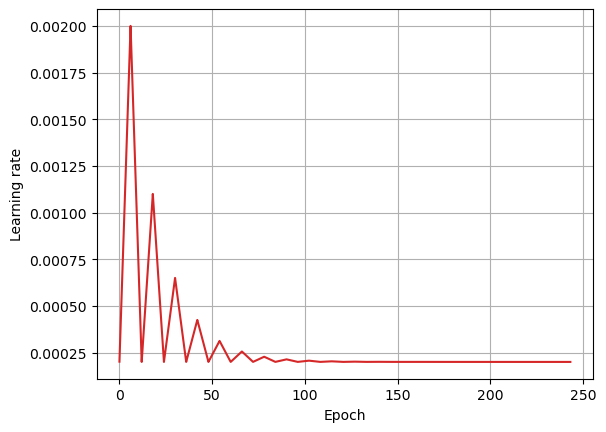

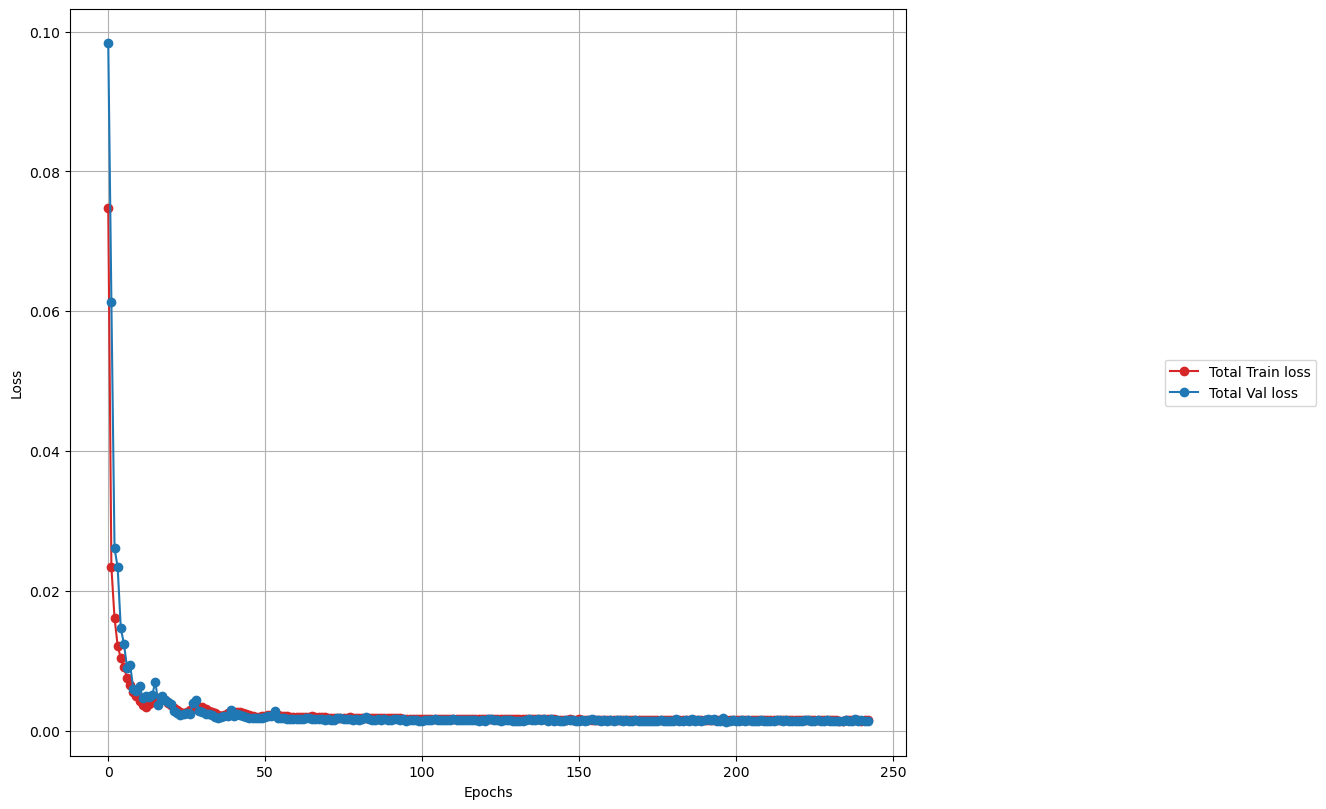

In [27]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")


losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(1,sharex=True, figsize=(15, 8))
ax.plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax.plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax.set(ylabel='Loss')
ax.grid()
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
plt.xlabel("Epochs")
plt.show()

<Figure size 640x480 with 0 Axes>

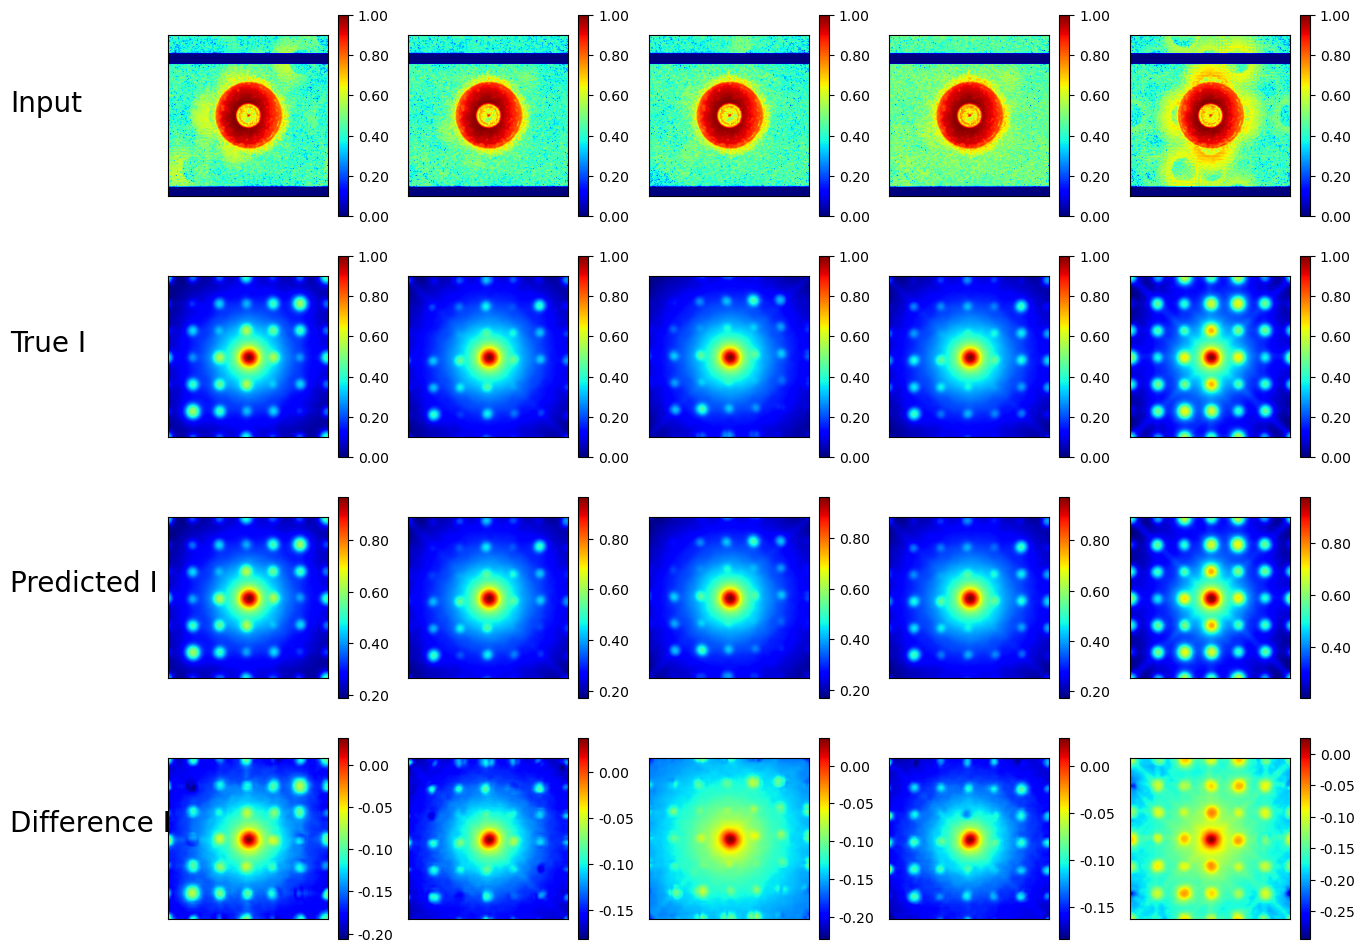

In [28]:
model.eval()
#model_new.eval() #imp when have dropout etc
results = []
for i, test in enumerate(testloader):
    tests = test[0].to(device)
    testsp = test[1].to(device)
    result = model(tests)
    for j in range(tests.shape[0]):
        results.append(result[j].detach().to("cpu").numpy())
        
results = np.array(results).squeeze()



h,w = H,W
ntest=results.shape[0]
plt.figure()
n = 5
f,ax=plt.subplots(4,n,figsize=(15, 12))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.6, "True I", fontsize=20)
plt.gcf().text(0.02, 0.4, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.2, "Difference I", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(X_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)

    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-results[j].reshape(h, w))#,norm=colors.LogNorm())
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
plt.show()

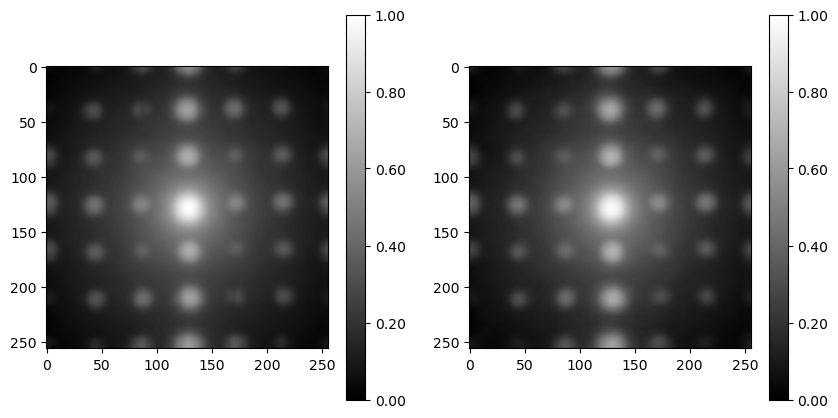

38.36993919777629


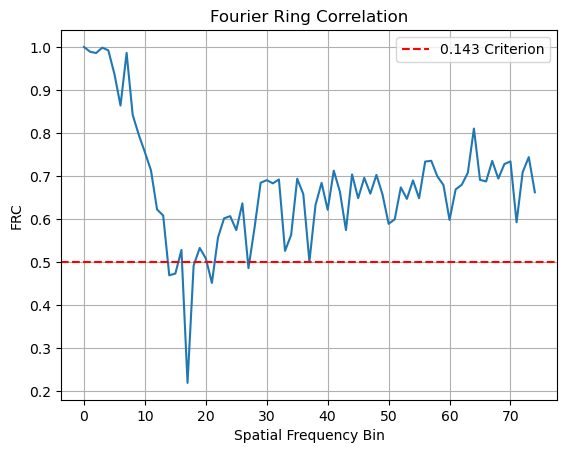

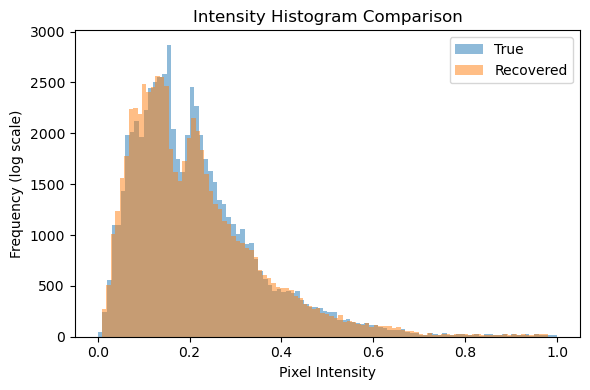

In [15]:
def compute_psnr(img_true, img_recon, max_val=1.0):
    """Compute PSNR between ground truth and reconstructed images."""
    mse = np.mean((img_true - img_recon) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 10 * np.log10((max_val ** 2) / mse)
    return psnr

def compute_frc(image1, image2, num_bins=50):
    """Compute the Fourier Ring Correlation between two images."""
    # Compute Fourier transforms
    F1 = fftshift(fft2(image1))
    F2 = fftshift(fft2(image2))

    fig,ax=plt.subplots(1,2,figsize=(10, 5))
    im1=ax[0].imshow(image1, cmap='gray',clim=(0,1))
    im2=ax[1].imshow(image2, cmap='gray',clim=(0,1))
    plt.colorbar(im1, ax=ax[0], format='%.2f')
    plt.colorbar(im2, ax=ax[1], format='%.2f')
    plt.show()
    # Prepare coordinates
    h, w = F1.shape
    y, x = np.indices((h, w))
    center = (h // 2, w // 2)
    r = np.sqrt((x - center[1]) ** 2 + (y - center[0]) ** 2)

    # Bin radial frequencies
    r = r.astype(np.int32)
    max_r = min(center)
    frc = np.zeros(num_bins)
    for i in range(num_bins):
        ring_mask = (r >= i * max_r / num_bins) & (r < (i + 1) * max_r / num_bins)
        F1_ring = F1[ring_mask]
        F2_ring = F2[ring_mask]
        num = np.sum(F1_ring * np.conj(F2_ring))
        denom = np.sqrt(np.sum(np.abs(F1_ring) ** 2) * np.sum(np.abs(F2_ring) ** 2))
        frc[i] = np.abs(num / denom) if denom != 0 else 0
    return frc

def plot_intensity_histograms(img1, img2, labels=('True', 'Recovered'), bins=100):
    plt.figure(figsize=(6,4))
    plt.hist(img1.ravel(), bins=bins, alpha=0.5, label=labels[0])
    plt.hist(img2.ravel(), bins=bins, alpha=0.5, label=labels[1])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency (log scale)')
    plt.title('Intensity Histogram Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
j=int(round(np.random.rand()*ntest))
IMAGE1=Y_I_test[j].reshape(h, w)   
IMAGE2=results[j].reshape(h, w)
frc_curve = compute_frc(IMAGE1, IMAGE2,num_bins=75)
print(compute_psnr(IMAGE1, IMAGE2))
plt.plot(frc_curve)
plt.axhline(0.5, color='r', linestyle='--', label='0.143 Criterion')
plt.xlabel('Spatial Frequency Bin')
plt.ylabel('FRC')
plt.title('Fourier Ring Correlation')
plt.legend()
plt.grid(True)
plt.show()
plot_intensity_histograms(IMAGE1, IMAGE2)